# Phase 1: Data Loading & Cleaning
**Objective:** Prepare the raw Telco dataset for analysis by fixing data types and handling missing values.

### 1.1 Load Libraries & Dataset
First, we import the necessary libraries for data manipulation (Pandas, NumPy) and visualization (Matplotlib, Seaborn). We then load the dataset to begin our inspection.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Display the first 5 rows to verify loading
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 1.2 Data Cleaning: The `TotalCharges` Fix
**Critical Issue:** The `TotalCharges` column is initially read as an `object` (string) because it contains blank strings (`" "`) for customers with 0 tenure. If ignored, this predictive feature would be treated as categorical.

**Action:**
1. Force-convert `TotalCharges` to numeric, turning errors into `NaN`.
2. Identify and count these missing values.
3. Impute `NaN` with `0`, as these customers have not yet been charged.

In [3]:
# Force convert to numeric, turning errors (blank strings) into NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check how many missing values we created (these were the blank strings)
missing_count = df['TotalCharges'].isnull().sum()
print(f"Missing values in TotalCharges: {missing_count}")

# Fill missing values with 0
df['TotalCharges'] = df['TotalCharges'].fillna(0)

Missing values in TotalCharges: 11


### 1.3 Feature Standardization & Cleanup
To make the dataset consistent for analysis:
* **`SeniorCitizen`**: Converted from `0/1` integers to `No/Yes` to match other categorical columns.
* **`customerID`**: Dropped as it is a unique identifier with no predictive value.

In [4]:
# Convert SeniorCitizen to string for consistency
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

# Drop customerID
df.drop('customerID', axis=1, inplace=True)

### 1.4 Sanity Check & Class Distribution
Before proceeding to EDA, we verify the data types and check for **Class Imbalance**.

**Why check imbalance?**
If the "No Churn" class dominates (e.g., >70%), we cannot rely solely on accuracy metrics. We will need techniques like SMOTE or Class Weighting in later phases.

In [6]:
# Check for Class Imbalance
churn_rate = df['Churn'].value_counts(normalize=True)
print("Class Distribution:")
print(churn_rate)

# Display info to confirm types are correct
print("\nFinal Data Types:")
print(df.dtypes)

Class Distribution:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

Final Data Types:
gender                  str
SeniorCitizen           str
Partner                 str
Dependents              str
tenure                int64
PhoneService            str
MultipleLines           str
InternetService         str
OnlineSecurity          str
OnlineBackup            str
DeviceProtection        str
TechSupport             str
StreamingTV             str
StreamingMovies         str
Contract                str
PaperlessBilling        str
PaymentMethod           str
MonthlyCharges      float64
TotalCharges        float64
Churn                   str
dtype: object


# Phase 3: Feature Engineering
**Objective:** Create new features that capture customer behavior better than raw data.

### 3.1 Creating Tenure Cohorts
**Why?** Raw tenure (1, 2, 3 months) is noisy. Grouping them helps the model find patterns like "New Customers" vs. "Loyal Customers".

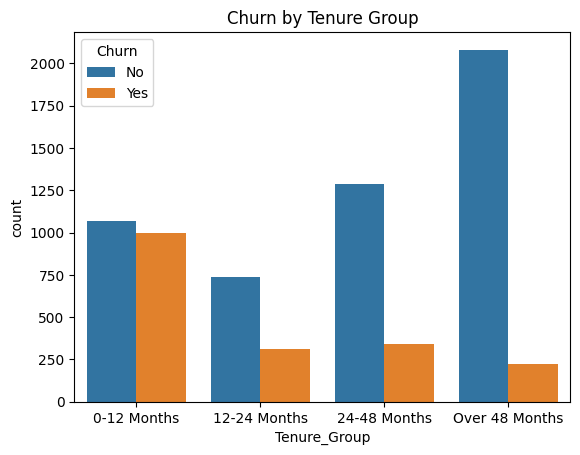

In [7]:
# 1. Tenure Cohorts (Binning)
def tenure_cohort(tenure):
    if tenure < 12:
        return '0-12 Months'
    elif tenure < 24:
        return '12-24 Months'
    elif tenure < 48:
        return '24-48 Months'
    else:
        return 'Over 48 Months'

df['Tenure_Group'] = df['tenure'].apply(tenure_cohort)

# Visualize the new groups
sns.countplot(x='Tenure_Group', hue='Churn', data=df, order=['0-12 Months', '12-24 Months', '24-48 Months', 'Over 48 Months'])
plt.title('Churn by Tenure Group')
plt.show()

### 3.2 Service Density (Stickiness)
**Why?** A customer with 5 services (Phone + Internet + Security...) is "stickier" (harder to leave) than someone with just 1. We will count the number of active services.

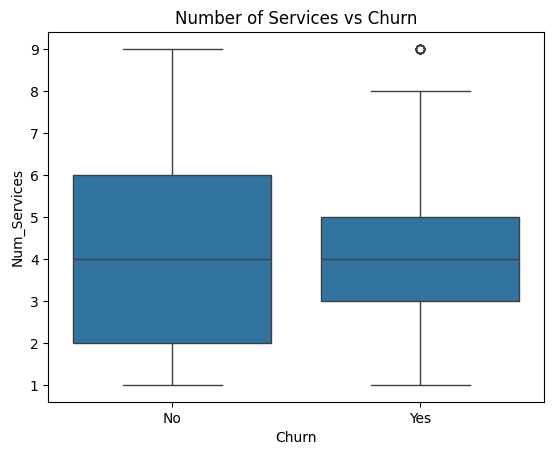

In [8]:
# 2. Count Number of Services
# List of service columns
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies']

# Helper function to count 'Yes' or specific services
def count_services(row):
    count = 0
    for col in service_cols:
        if row[col] == 'Yes' or row[col] == 'Fiber optic' or row[col] == 'DSL':
            count += 1
    return count

df['Num_Services'] = df.apply(count_services, axis=1)

# Check if more services = less churn?
sns.boxplot(x='Churn', y='Num_Services', data=df)
plt.title('Number of Services vs Churn')
plt.show()

# Phase 4: Data Preprocessing & Baseline Model
**Objective:** Convert data into numbers (Encoding) and train a simple Logistic Regression model as a benchmark.

### 4.1 Encoding Categorical Variables
Machine Learning models (mostly) require numbers, not strings like "Yes"/"No".
* **Target (`Churn`):** Convert to 1 (Yes) and 0 (No).
* **Features:** Use One-Hot Encoding (creates new columns for each category).

In [9]:
# 1. Encode Target (Churn)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 2. One-Hot Encoding for other categorical variables
# drop_first=True avoids the "dummy variable trap" for linear models
df_encoded = pd.get_dummies(df, drop_first=True)

print(f"New Data Shape: {df_encoded.shape}")
df_encoded.head()

New Data Shape: (7043, 35)


,tenure,MonthlyCharges,TotalCharges,Churn,Num_Services,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure_Group_12-24 Months,Tenure_Group_24-48 Months,Tenure_Group_Over 48 Months
0,1,29.85,29.85,0,2,False,False,True,False,False,...,False,False,False,True,False,True,False,False,False,False
1,34,56.95,1889.50,0,4,True,False,False,False,True,...,False,True,False,False,False,False,True,False,True,False
2,2,53.85,108.15,1,4,True,False,False,False,True,...,False,False,False,True,False,False,True,False,False,False
3,45,42.30,1840.75,0,4,True,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
4,2,70.70,151.65,1,2,False,False,False,False,True,...,False,False,False,True,False,True,False,False,False,False
